In [96]:
import sys
import os
import os.path
import fnmatch
from lxml import etree
from lxml.etree import tostring
import re
from collections import defaultdict
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pylab import plot
import pickle
import re

In [25]:
def process_files(list_of_files, path_in):
    
    words_dict=defaultdict(list)
    chaps_dict=defaultdict(list)
    plot_words=OrderedDict()
    plot_chaps=OrderedDict()
    filtered=list()
    bugs=list()
    stats=defaultdict(list)
    
    print("Processing "+str(len(list_of_files))+" files. Please wait, this might take some time.")

    for tmpFile in list_of_files:

        tmpFile=tmpFile.replace("/",":")
        fullPath=path_in+tmpFile

        #print("\nProcessing file "+tmpFile)

        if os.path.isfile(fullPath):
            tree=etree.parse(fullPath)

        #yearKey=int(tmpFile[:3]+"0")
            yearKey=int(tmpFile[:4])

            words_dict=num_words(words_dict,tree, yearKey, bugs, tmpFile)
            #print(words_dict.keys())
            chap_dict=num_chapters(chaps_dict,tree,yearKey, bugs,tmpFile)

    plot_words=words_for_plot(words_dict, plot_words)
    plot_chaps=words_for_plot(chaps_dict, plot_chaps)
    #print(bugs)
    fit_words = lin_reg(plot_words)
    fit_chaps = lin_reg(plot_chaps)
    
    stats["chapter"].append(fit_chaps)
    stats["chapter"].append(plot_chaps)
    stats["word"].append(fit_words)
    stats["word"].append(plot_words)
    
    return stats

    #del filtered
    del words_dict
    del chaps_dict
    del plot_words
    del plot_chaps

In [26]:
def lin_reg(series):

    x = np.array(list(series.keys()))
    y = np.array(list(series.values()))

    x = sm.add_constant(x)

    return sm.OLS(y, x).fit()

In [27]:
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

In [206]:
def plot_stats (fit, plot, title):
    x1 = list(plot.keys())[0]
    x2 = list(plot.keys())[-1]
    y1 = fit.predict()[0]
    y2 = fit.predict()[-1]
    x = np.array(list(plot.keys()))
    y = np.array(list(plot.values()))
    #print(len(plot.values()))
    yMA = movingaverage(y,5)
    plt.figure(figsize=(10, 6))
    plt.plot(list(plot.keys()), list(plot.values()))
    plt.plot(x[len(x)-len(yMA):],yMA,linewidth=5)
    plt.title(title)
    plt.plot([x1, x2], [y1, y2], color='gray', linewidth=0.5)
    plt.xlim(min(plot.keys()),max(plot.keys()))
    plt.ylim(min(plot.values()),max(plot.values()))
    #print(plot.keys())
    plt.show()

In [200]:
def multiple_plots (stats):
    plt.figure(figsize=(10, 6))
    for name in stats.keys():
        x=np.array(list(stats[name]['word'][1].keys()))
        y=np.array(list(stats[name]['word'][1].values()))
        yMA = movingaverage(y,5)
        plt.plot(x[len(x)-len(yMA):],yMA,label=name[1:])
        plt.ylim(min(stats[name]['word'][1].keys()),30000)
        plt.xlim(1840,1910)
    plt.legend(loc='upper left')
    plt.title("nombre moyen de mots par chapitre")
    plt.show()
    plt.figure(figsize=(10, 6))
    for name in stats.keys():
        x=np.array(list(stats[name]['chapter'][1].keys()))
        y=np.array(list(stats[name]['chapter'][1].values()))
        yMA = movingaverage(y,5)
        plt.plot(x[len(x)-len(yMA):],yMA,label=name[1:])
        plt.ylim(0,40)
        plt.xlim(1840,1910)
    plt.legend(loc='upper left')
    plt.title("nombre moyen de chapitres")
    plt.show()

In [29]:
def num_words (words_dict,tree,yearKey,bugs,tmpFile):
    execute=False
    words=list()
    if tree.findall(".//div[@type='chapter']"):
        for chapter in tree.findall(".//div[@type='chapter']"):
            tmp="".join(chapter.itertext())
            numWords=len(re.split('[\n\s]+',tmp))
            words.append(numWords)
            execute=True
            #print(chapter.attrib["title"])
            #print(numWords)
    elif tree.findall(".//div[@type='part']"):
        for chapter in tree.findall(".//div[@type='part']"):
            tmp="".join(chapter.itertext())
            numWords=len(re.split('[\n\s]+',tmp))
            words.append(numWords)
            execute=True
    
    else :
        bugs.append(tmpFile+" ; ")
        execute=False
    
    if execute==True:
        average=sum(words)/len(words)
        words_dict[yearKey].append(average)
    return words_dict

In [30]:
def num_chapters (chaps_dict,tree, yearKey,bugs,tmpFile):
    execute=False
    chapters=list()
    if tree.findall(".//div[@type='chapter']"):
        num_chaps=len(tree.findall(".//div[@type='chapter']"))
        execute=True
        #print("Pour l'année : "+str(yearKey))
        #print(num_chaps)
    elif tree.findall(".//div[@type='part']"):
        num_chaps=len(tree.findall(".//div[@type='part']"))
        execute=True
    
    else :
        bugs.append(tmpFile+" ; ")
        execute=False
    
    if execute==True:
        chaps_dict[yearKey].append(num_chaps)
        #print(len(chap_dict[yearKey]))
        #print(chap_dict[yearKey])
    return chaps_dict

In [31]:
def words_for_plot (words_dict, plot_words):
    for year in sorted(words_dict.keys()):
        if len(words_dict[year])>0:
        #moyenne nombre de mots par année
            plot_words[year]=sum(words_dict[year])/len(words_dict[year])
    return plot_words

In [32]:
def by_attribute (list_of_files, path_in, lxml_string):
    filtered=list()
    for tmpFile in list_of_files:

        fullPath=path_in+tmpFile.replace("/",":")

        #print("\nProcessing file "+tmpFile)

        if os.path.isfile(fullPath):
            tree=etree.parse(fullPath)
        
            if tree.findall(lxml_string):
                filtered.append(tmpFile)
    return filtered

In [59]:
def by_name (list_of_files, path_in, author):
    files_by_author=list()
    for tmpFile in list_of_files:
        fullPath=path_in+tmpFile.replace("/",":")
        if os.path.isfile(fullPath):
            result = re.search('[0-9]{4}(.*)_', tmpFile)
            name= result.group(1)
            if author in name:
                files_by_author.append(tmpFile)
    return files_by_author

In [176]:
%matplotlib inline
path_to_folder='/home/odysseus/Bureau/ANR/stats/romans/'
authors=['_Dumas','_Zola','_Maupassant','_Verne']
editors=['_Dumas','_Zola','_Maupassant','_Verne']

print("Statistiques globales : ")
files_list=fnmatch.filter(os.listdir(path_to_folder), '*.xml')

stats_authors=OrderedDict()
for author in authors:
    names=by_name(files_list, path_to_folder,author)
    stats_authors[author]=process_files(names, path_to_folder)
pickle.dump(stats_authors, open("stats_authors","wb"))
    
#stats_global=process_files(files_list, path_to_folder, output_csv)

#canon_list=by_attribute(files_list, path_to_folder,".//profileDesc[@tag='canon']")
#stats_canon=process_files(canon_list, path_to_folder, output_csv)

#pickle.dump(stats_global, open("stats_global","wb"))
#pickle.dump(stats_canon, open("stats_canon","wb"))

Statistiques globales : 
Processing 136 files. Please wait, this might take some time.
Processing 28 files. Please wait, this might take some time.
Processing 47 files. Please wait, this might take some time.
Processing 53 files. Please wait, this might take some time.


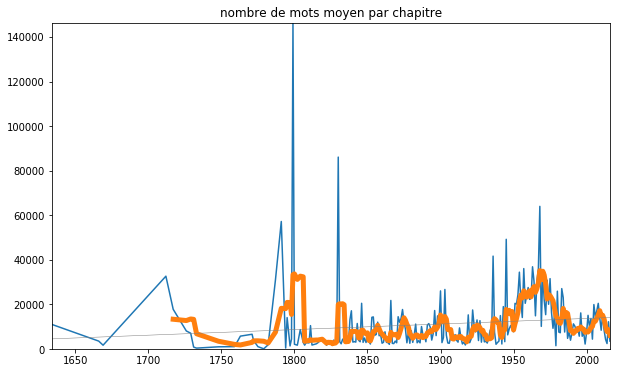

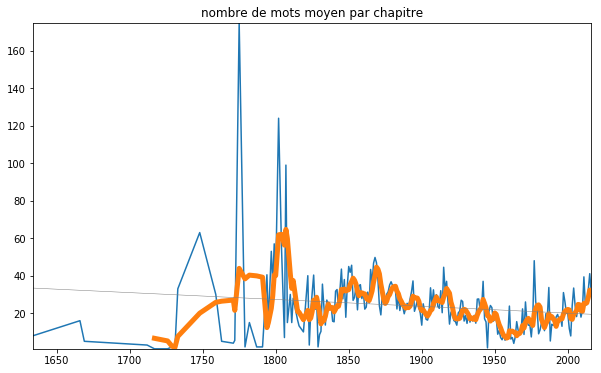

In [207]:
stats_global=pickle.load(open( "stats_global", "rb"))
plot_stats(stats_global["word"][0],stats_global["word"][1],"nombre de mots moyen par chapitre")
plot_stats(stats_global["chapter"][0],stats_global["chapter"][1],"nombre de mots moyen par chapitre")

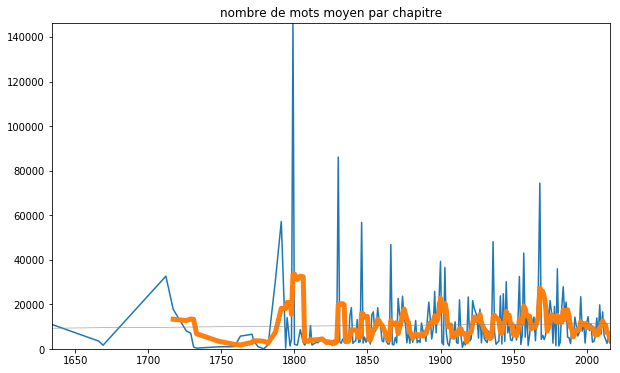

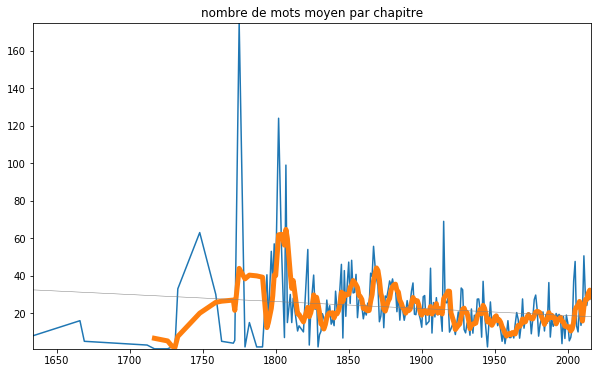

In [210]:
stats_canon=pickle.load(open( "stats_canon", "rb"))
plot_stats(stats_canon["word"][0],stats_canon["word"][1],"nombre de mots moyen par chapitre")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],"nombre de mots moyen par chapitre")

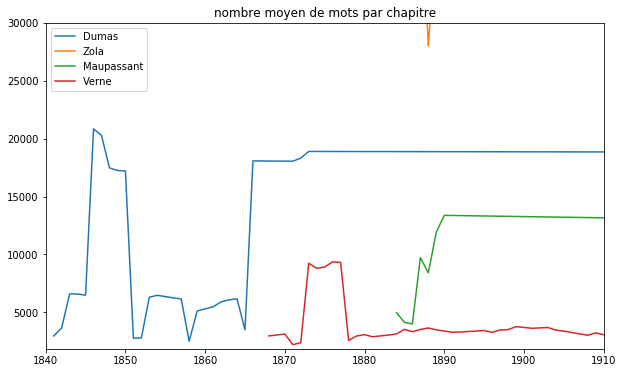

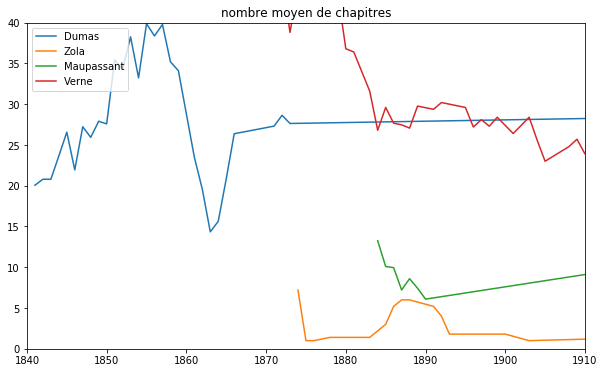

In [209]:
stats_authors=pickle.load(open("stats_authors","rb"))
multiple_plots(stats_authors)